In [19]:
# Starter

__author__ = "Philipp Kats"
from datetime import date
__date__ = date.today().strftime('%Y-%m-%d')

%matplotlib inline
import pylab as plt
plt.style.use('fivethirtyeight')

import pandas as pd
import geopandas as gp
import os
import json
import SE
import altair as alt

from tqdm import tqdm, tqdm_notebook
# tqdm().pandas()
#from hyperdash import monitor_cell, Experiment
 

from SE.areas import get_all_areas, get_larger_area
from SE.sql import _get_DF
from SE import definitions
#from SE.sql import queries
idx = pd.IndexSlice

print(__date__)
print(SE.__version__)

2018-09-10
5.8.6


In [20]:
from SE.spatial import get_better_boundaries, NYC_CRS, MERCATOR_CRS
nyc = get_better_boundaries(area_type='city', nyc_crs=True)

In [21]:
cb = pd.read_pickle('../data/correct_geom.pkl')

Text(0.5,1,'Sample')

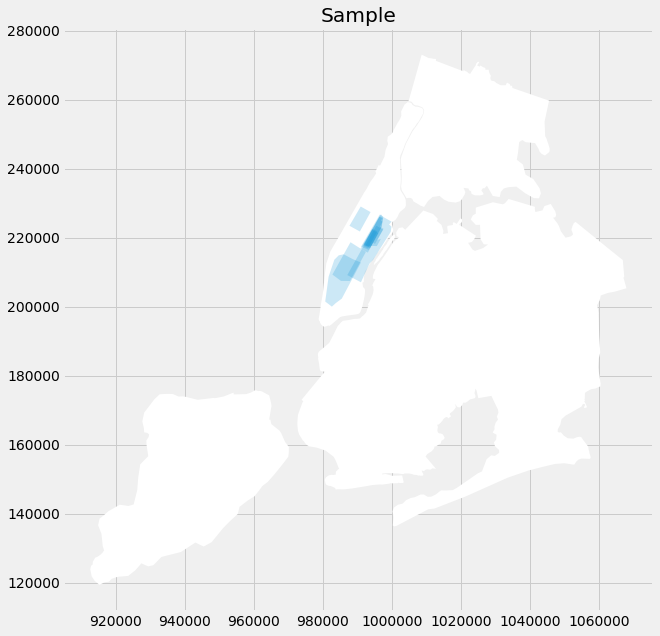

In [22]:
ax=nyc.plot(figsize=(10,10), facecolor='white')
cb.head(10).plot(ax=ax, alpha=.2)
plt.title('Sample')

## bd visualisation

In [23]:
from rasterio import features, Affine, float64
from rasterio.enums import MergeAlg
from xarray import DataArray
import numpy as np

import datashader as ds
from datashader import transfer_functions as tf, reductions as rd
from datashader.colors import Hot, viridis

In [24]:
import colorcet
kbc = colorcet.cm.kbc

In [25]:
def get_transform(cvs):
    '''transform into canvas coordinates'''
    return Affine((cvs.x_range[1] - cvs.x_range[0]) / cvs.plot_width, 0.0,
                   cvs.x_range[0], 0.0, (cvs.y_range[0] - cvs.y_range[1]) / cvs.plot_height, cvs.y_range[1])

In [26]:
print(nyc['geometry'].iloc[0].envelope.buffer(.05).envelope)
## slightly offcet from NYC borders

POLYGON ((912612.5756563748 119435.5517043253, 1068023.635515791 119435.5517043253, 1068023.635515791 273101.639647286, 912612.5756563748 273101.639647286, 912612.5756563748 119435.5517043253))


In [27]:
cvs = ds.Canvas(plot_height=2000,
                plot_width=2000,
                x_range=(912_612, 1_068_023),
                y_range=(119435, 273101))

aform = get_transform(cvs)
aform

Affine(77.7055, 0.0, 912612.0,
       0.0, -76.833, 273101.0)

In [54]:
border = features.rasterize([nyc.iloc[0].geometry.boundary], 
                            out_shape=(cvs.plot_height, cvs.plot_width),
                            merge_alg=MergeAlg.replace, transform=aform, all_touched=True, dtype=float64)

border[border == 0] = np.nan
bd = DataArray(data=pd.np.flipud(border))

## Density Map

In [57]:
# boundaries = cb['geometry'].tolist()
boundaries = cb['geometry'].tolist()

In [58]:
F = features.rasterize([(el, 1) for el in boundaries],  out_shape=(cvs.plot_height, cvs.plot_width), merge_alg=MergeAlg.add, transform=aform, dtype=float64)

In [59]:
df = DataArray(data=pd.np.flipud(F))

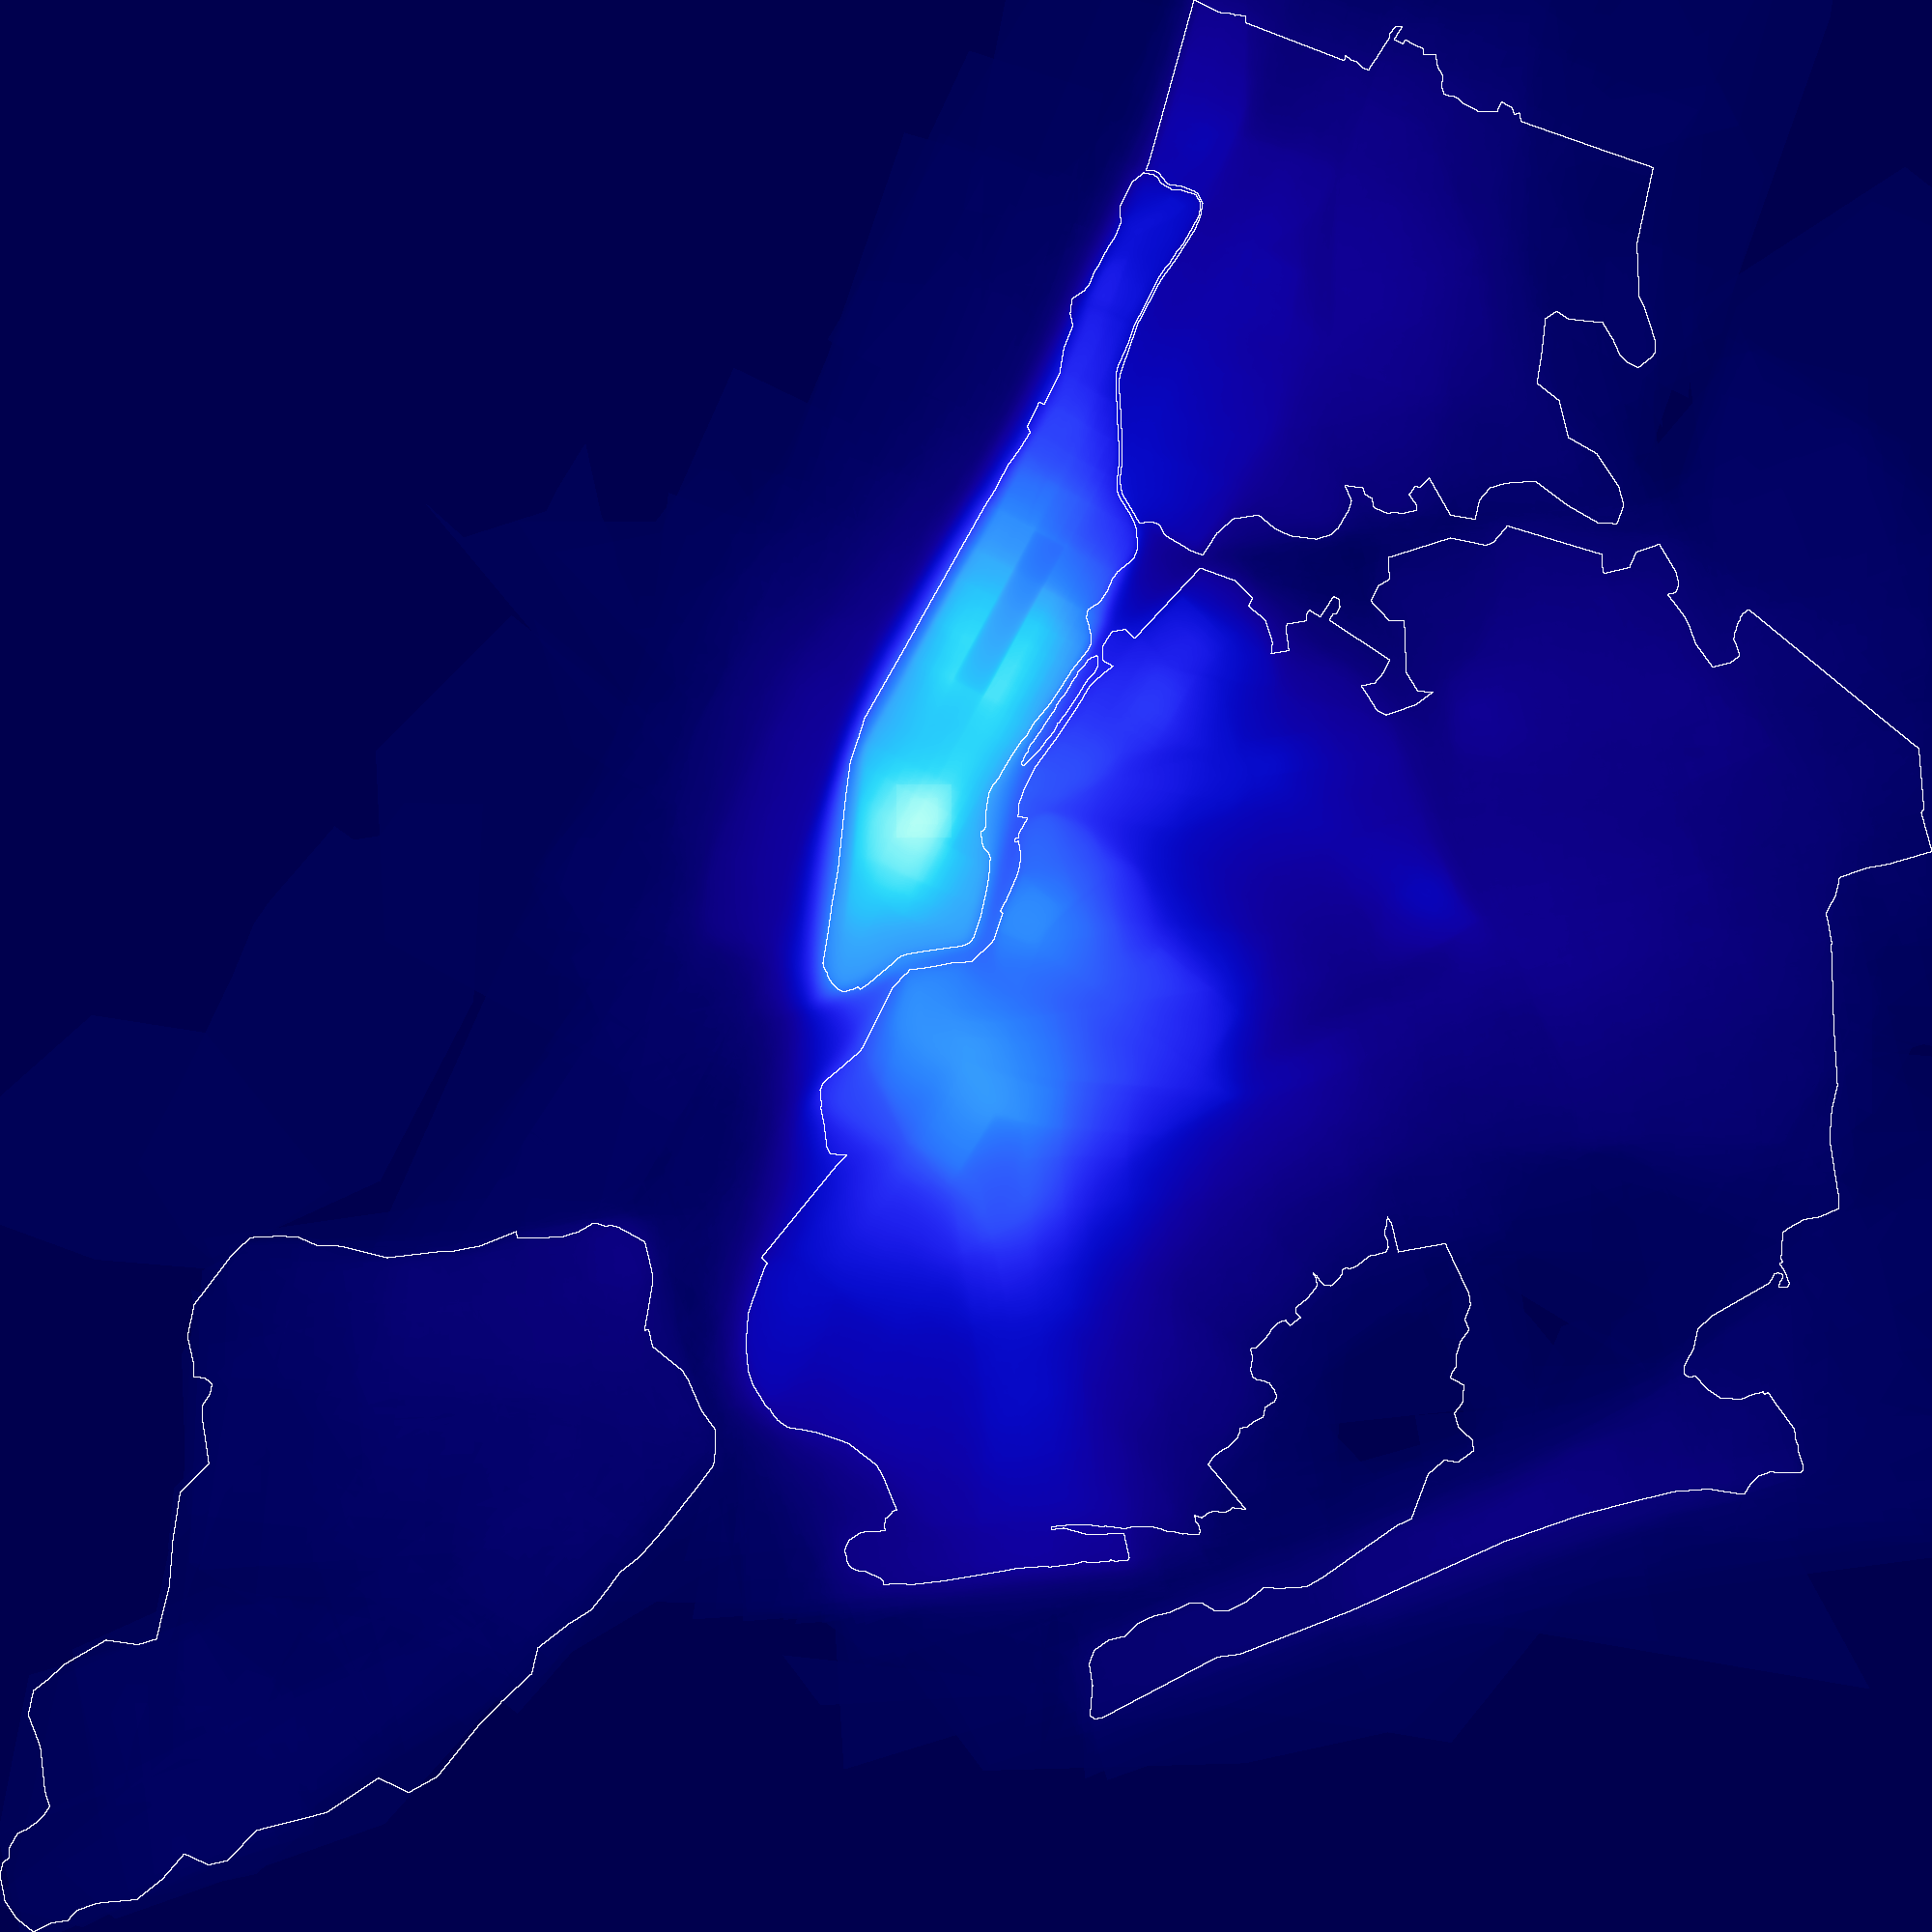

In [60]:
tf.stack(tf.shade(df, how='cbrt', cmap=kbc, name='Density'),
         tf.shade(bd, how='eq_hist', cmap=['black','white']))

## Plot boundaries

In [61]:
Fb = features.rasterize([(el, 1) for el in cb['geometry'].boundary.tolist()], 
                        out_shape=(cvs.plot_height, cvs.plot_width), merge_alg=MergeAlg.add,
                        transform=aform, dtype=float64, all_touched=True)

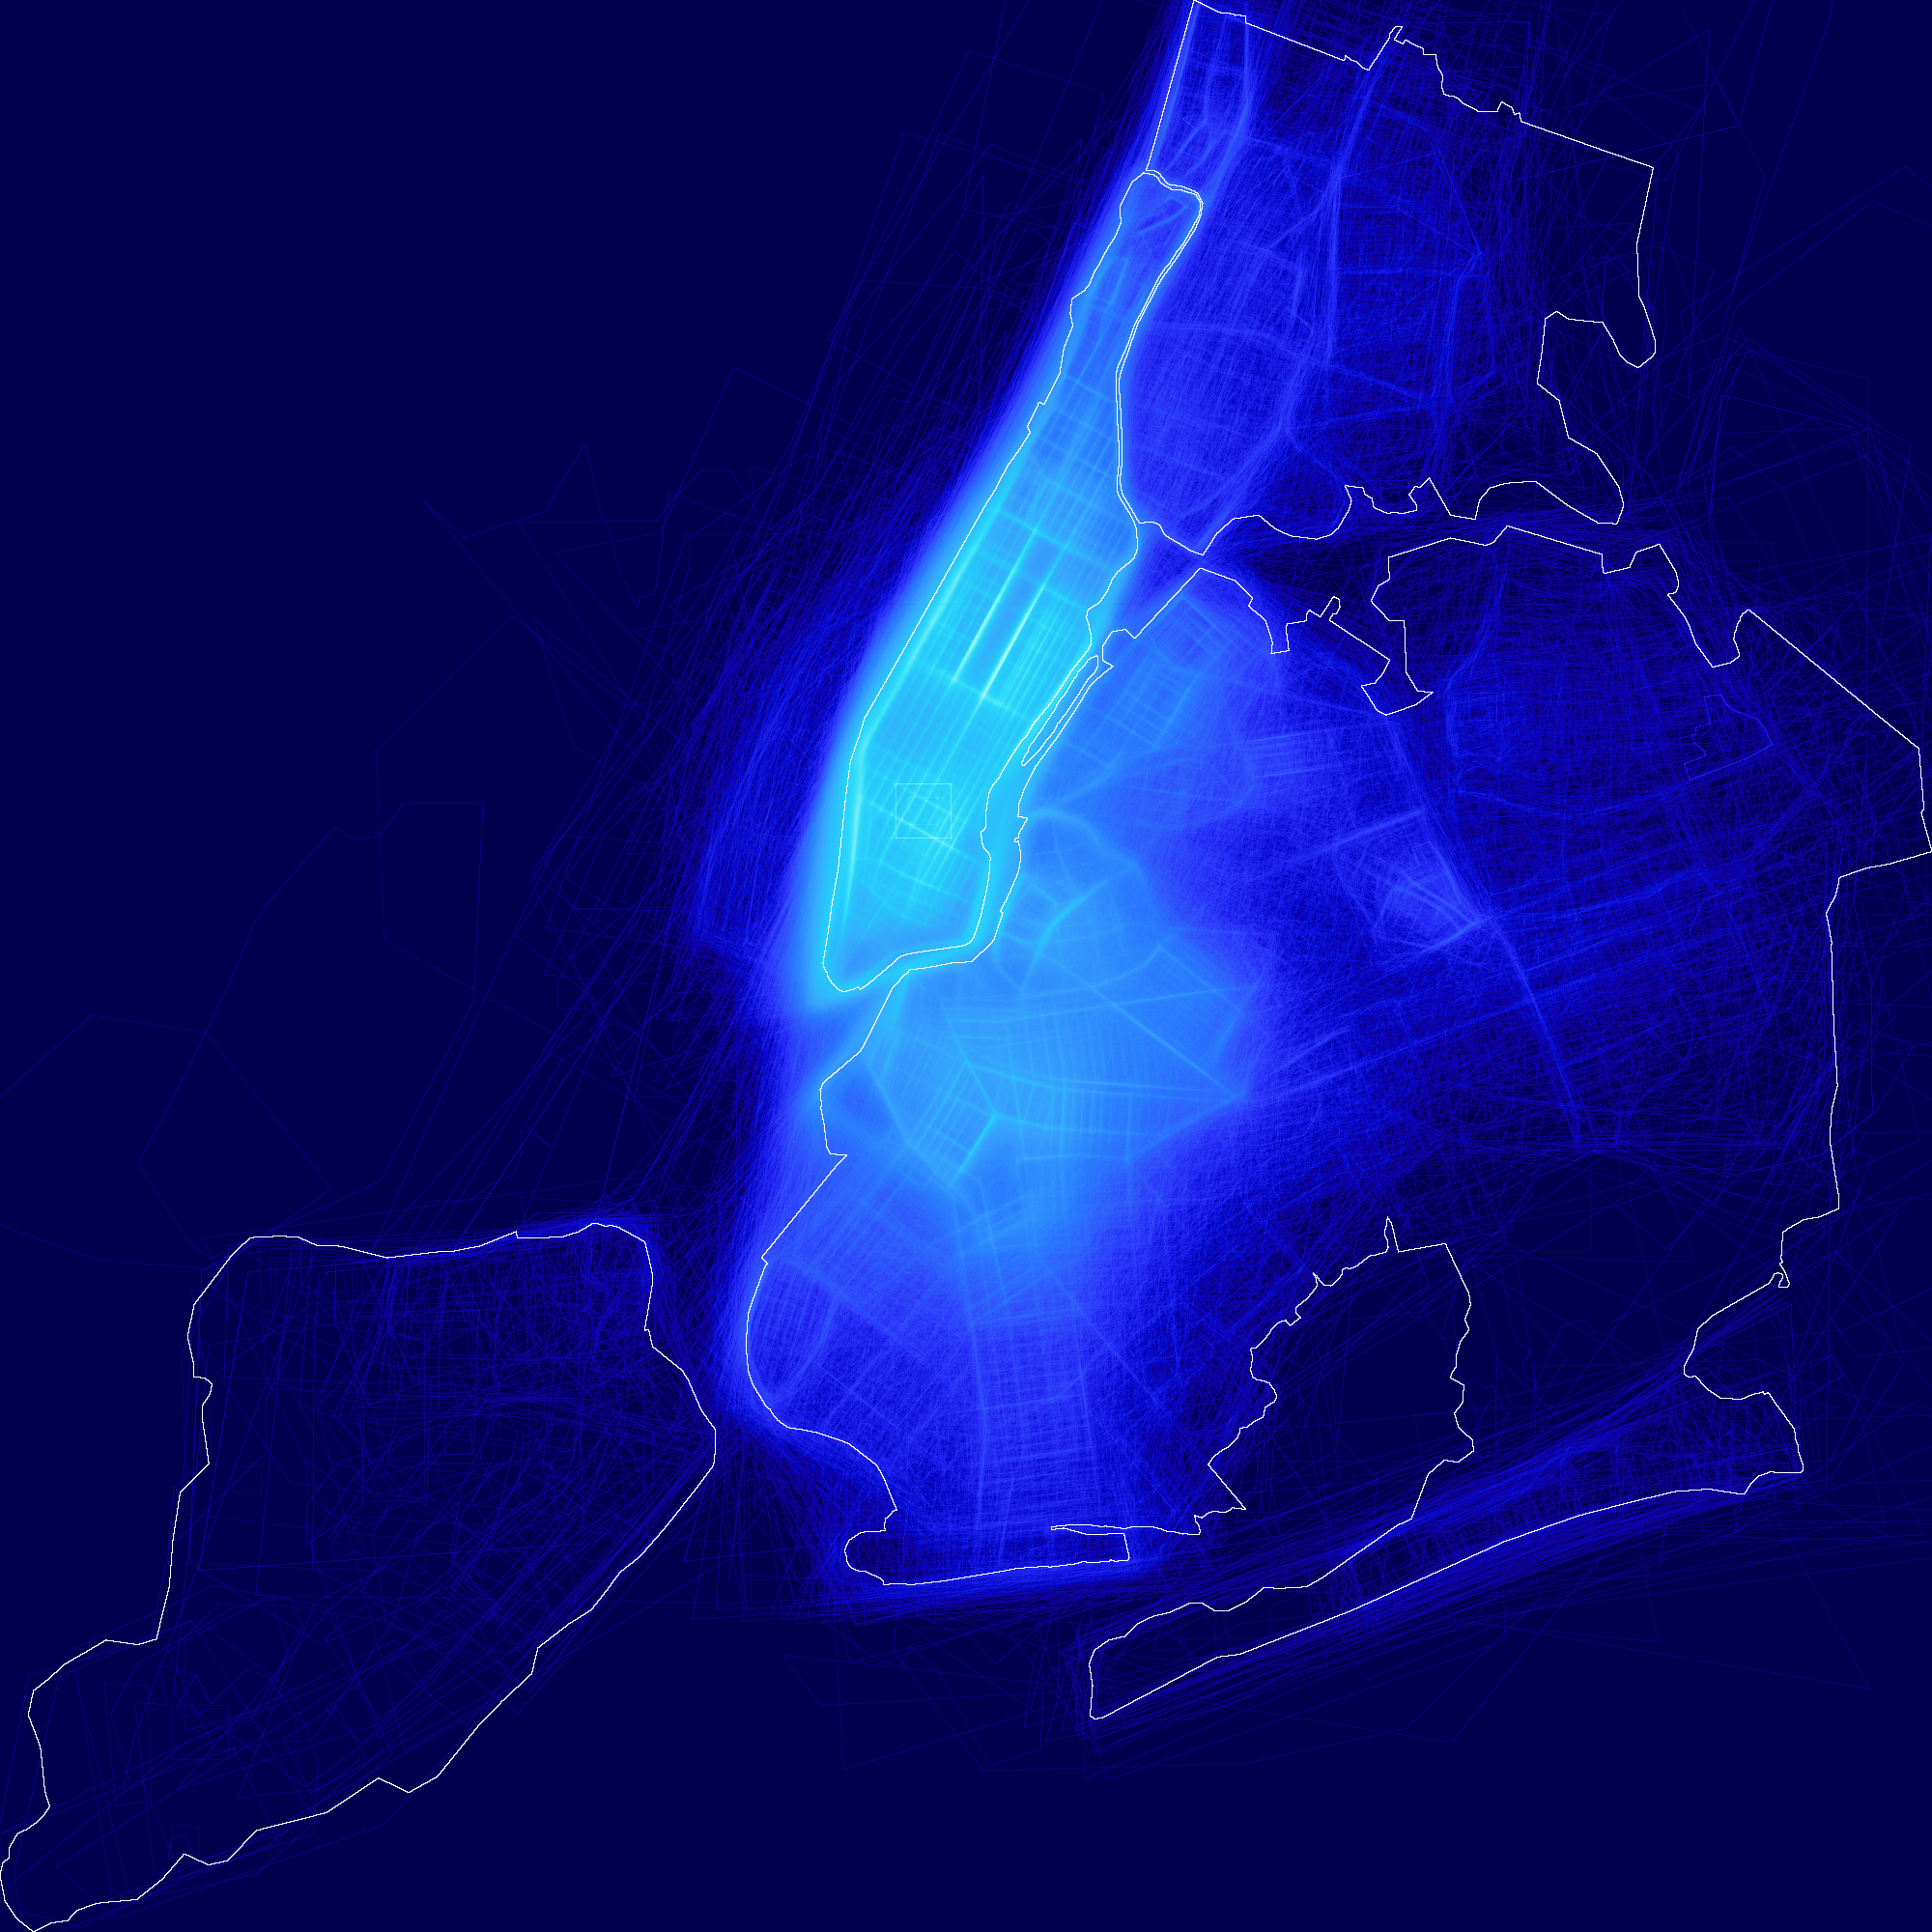

In [62]:
# Fb[Fb == 0 ] = np.nan
df2 = DataArray(data=pd.np.flipud(Fb))

tf.stack(tf.shade(df2, how='log', cmap=kbc, name='Density'),
         tf.shade(bd, how='eq_hist', cmap=['black','white']))